In [2]:
from paths import DATA_DIR, CKPT_FOLDER, PROJECT_FOLDER

import matplotlib.pyplot as plt
import numpy as np
import torch
import scanpy as sc
import scvelo as scv

import anndata
import pandas as pd

from torchdyn.core import NeuralODE

from scCFM.datamodules.time_sc_datamodule import TrajectoryDataModule
from scCFM.models.cfm.components.mlp import MLP
from scCFM.models.cfm.cfm_module import CFMLitModule
from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE
from scCFM.datamodules.sc_datamodule import scDataModule
from scCFM.models.cfm.components.eval.distribution_distances import compute_distribution_distances

from notebooks.utils import (standardize_adata,
                             add_keys_to_dict,
                             real_reconstructed_cells_adata,
                             add_velocity_to_adata, 
                             compute_velocity_projection, 
                             compute_trajectory, 
                             decode_trajectory)

In [3]:
# sc.set_figure_params(scanpy=True,
#                          dpi=90, 
#                          dpi_save=150,
#                          frameon=False, 
#                          vector_friendly=True,
#                          fontsize=14, 
#                          figsize=None,
#                          color_map=None, 
#                          format='pdf', 
#                          facecolor=None, 
#                          transparent=False, 
#                          ipython_format='png2x')


# scv.set_figure_params('scvelo', transparent=True, fontsize=20)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

**Read the anndata files**

First, read the latent space anndata and plot the results

In [5]:
adata_latent_vae = sc.read_h5ad(DATA_DIR / "eb" / "flat" / "eb_lib.h5ad")
adata_latent_flat = sc.read_h5ad(DATA_DIR / "eb" / "flat" / "eb_flat_lib.h5ad")

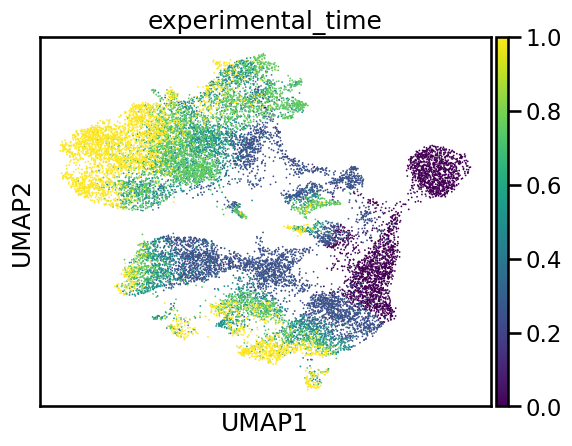

In [6]:
sc.pl.umap(adata_latent_vae, color="experimental_time")

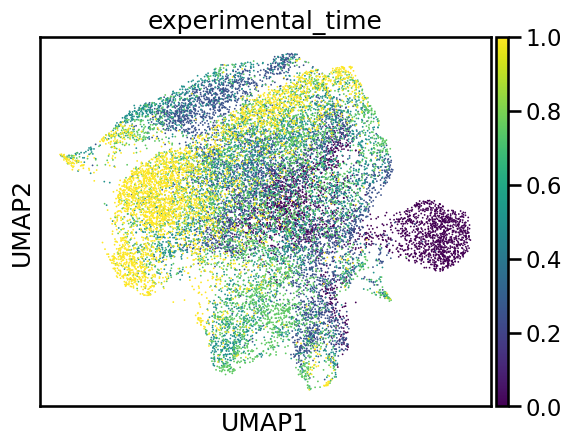

In [7]:
sc.pl.umap(adata_latent_flat, color="experimental_time")

Initialize datamodule

In [8]:
datamodule_kwargs_vae = {'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/flat/eb_lib.h5ad',
                          'x_layer': 'X_latents',
                          'time_key': 'experimental_time', 
                          'use_pca': False, 
                          'n_dimensions': None, 
                          'train_val_test_split': [0.9, 0.1], 
                          'num_workers': 2, 
                          'batch_size': 512, 
                          'model_library_size': True}

datamodule_kwargs_flat = {'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/flat/eb_flat_lib.h5ad',
                          'x_layer': 'X_latents',
                          'time_key': 'experimental_time', 
                          'use_pca': False, 
                          'n_dimensions': None, 
                          'train_val_test_split': [0.9, 0.1], 
                          'num_workers': 2, 
                          'batch_size': 512, 
                           'model_library_size': True}

# Initialize the datamodules 
datamodule_vae = TrajectoryDataModule(**datamodule_kwargs_vae)
datamodule_flat = TrajectoryDataModule(**datamodule_kwargs_flat)

# Mapping real times to index
idx2time = datamodule_vae.idx2time

Velocity field network

In [9]:
net_hparams = {"dim": datamodule_vae.dim,
                "w": 64,
                "time_varying": True}

net_vae = MLP(**net_hparams).to(device)
net_flat = MLP(**net_hparams).to(device)

CFM model 

In [10]:
cfm_kwargs = {'ot_sampler': 'exact', 
                   'sigma': 0.1, 
                   'use_real_time': False, 
                   'lr': 0.001, 
                   'antithetic_time_sampling': True}

cfm_vae = CFMLitModule(net=net_vae, datamodule=datamodule_vae, **cfm_kwargs).to(device)
cfm_flat = CFMLitModule(net=net_flat, datamodule=datamodule_flat, **cfm_kwargs).to(device)

In [11]:
cfm_vae.load_state_dict(torch.load(CKPT_FOLDER / "trajectory" / "eb" / "best_cfm_model_eb.ckpt")["state_dict"])
cfm_flat.load_state_dict(torch.load(CKPT_FOLDER / "trajectory" / "eb" / "best_cfm_model_flat_eb.ckpt")["state_dict"])

<All keys matched successfully>

**Add velocities to anndata and plot them onto the umap and pca**

In [12]:
add_velocity_to_adata(adata_latent_vae, cfm_vae, device)
add_velocity_to_adata(adata_latent_flat, cfm_flat, device)

Non geometric

  0%|          | 0/18176 [00:00<?, ?cell/s]

  0%|          | 0/18176 [00:00<?, ?cell/s]

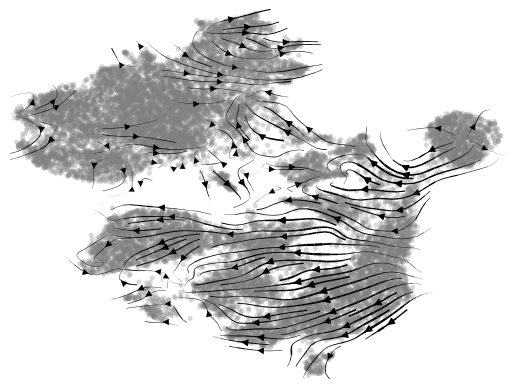

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


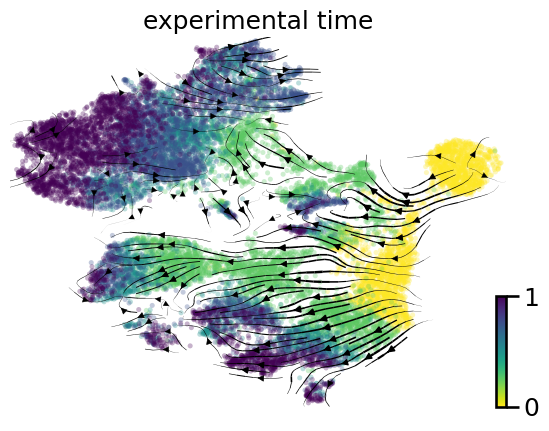

In [13]:
vk_vae_umap = compute_velocity_projection(adata_latent_vae, "X_latents", "velocity")
vk_vae_umap.compute_transition_matrix().plot_projection()
scv.pl.velocity_embedding_stream(adata_latent_vae, vkey="T_fwd", basis="umap", color="experimental_time")

  0%|          | 0/18176 [00:00<?, ?cell/s]

  0%|          | 0/18176 [00:00<?, ?cell/s]

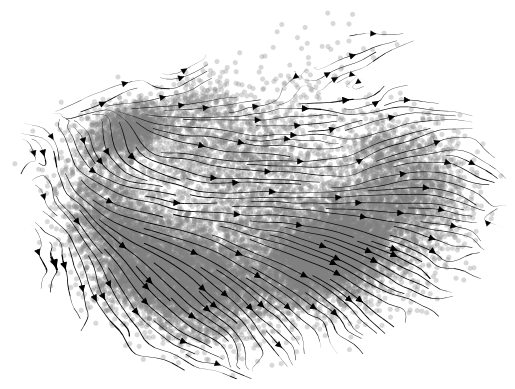

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


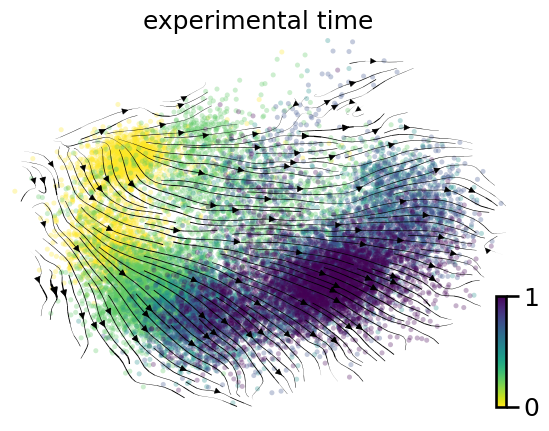

In [14]:
vk_vae_pca = compute_velocity_projection(adata_latent_vae, "X_latents", "velocity")
vk_vae_umap.compute_transition_matrix().plot_projection(basis="pca")
scv.pl.velocity_embedding_stream(adata_latent_vae, vkey="T_fwd", basis="pca", color="experimental_time")

Geometric

  0%|          | 0/18176 [00:00<?, ?cell/s]

  0%|          | 0/18176 [00:00<?, ?cell/s]

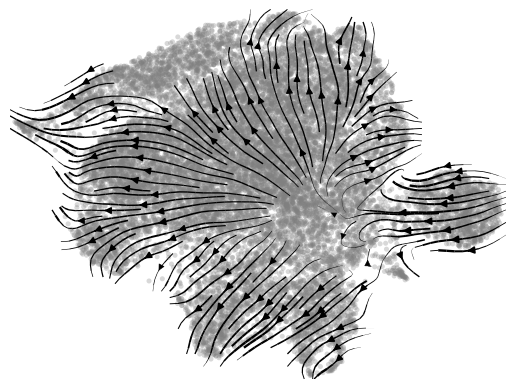

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


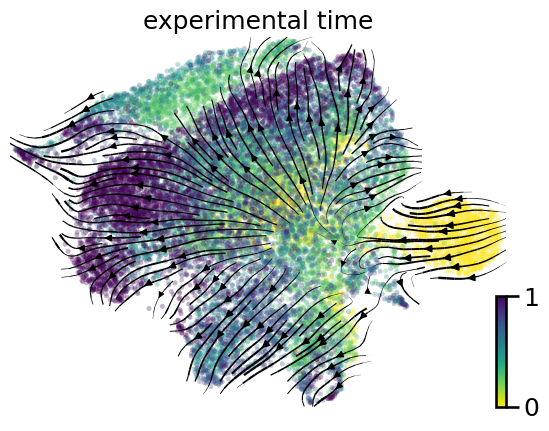

In [15]:
vk_flat_umap = compute_velocity_projection(adata_latent_flat, "X_latents", "velocity")
vk_flat_umap.compute_transition_matrix().plot_projection(basis="umap")
scv.pl.velocity_embedding_stream(adata_latent_flat, vkey="T_fwd", basis="umap", color="experimental_time")

  0%|          | 0/18176 [00:00<?, ?cell/s]

  0%|          | 0/18176 [00:00<?, ?cell/s]

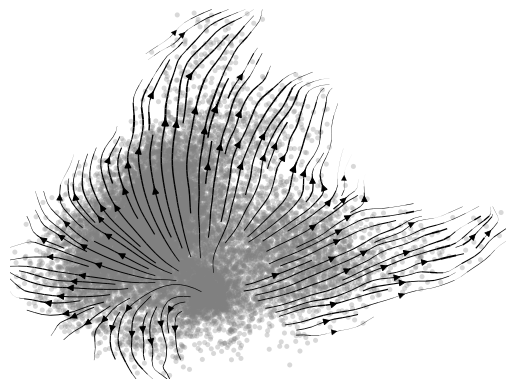

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


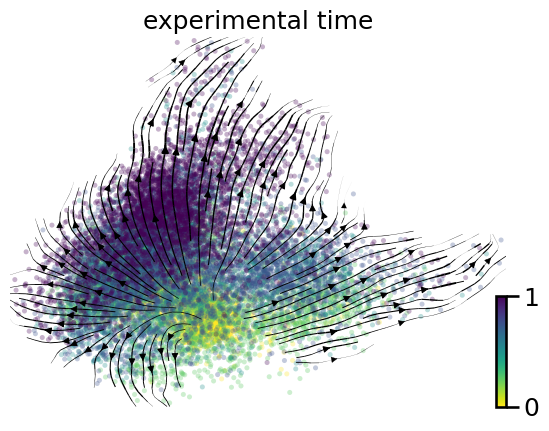

In [16]:
vk_flat_pca = compute_velocity_projection(adata_latent_flat, "X_latents", "velocity")
vk_flat_pca.compute_transition_matrix().plot_projection(basis="pca")
scv.pl.velocity_embedding_stream(adata_latent_flat, vkey="T_fwd", basis="pca", color="experimental_time")

**Evaluate push forward from time 0**

In [17]:
#Pick time 0 observations
X_adata_t0_vae = torch.from_numpy(adata_latent_vae[adata_latent_vae.obs["experimental_time"]==0].X).to(device)
X_adata_t0_flat = torch.from_numpy(adata_latent_flat[adata_latent_flat.obs["experimental_time"]==0].X).to(device)

#Library values of observations at time 0
l_t0_vae = adata_latent_vae.obs.loc[adata_latent_vae.obs["experimental_time"]==0, "log_library_size"].to_numpy()
l_t0_flat = adata_latent_flat.obs.loc[adata_latent_flat.obs["experimental_time"]==0, "log_library_size"].to_numpy()
l_t0_vae = torch.from_numpy(l_t0_vae).to(device)
l_t0_flat = torch.from_numpy(l_t0_flat).to(device)

In [18]:
# Collect latent trajectories
traj_vae, times_vae = compute_trajectory(X_adata_t0_vae, 
                                         l_t0_vae,
                                         cfm_vae, 
                                         idx2time, 
                                         device, 
                                         use_real_time=False)

traj_flat, times_flat = compute_trajectory(X_adata_t0_flat, 
                                           l_t0_flat,
                                           cfm_flat, 
                                           idx2time, 
                                           device, 
                                           use_real_time=False)

# Convert times to data frames to put them into the anndata object 
times_vae = pd.DataFrame(times_vae)
times_flat = pd.DataFrame(times_flat)
times_vae.columns = ["experimental_time"]
times_flat.columns = ["experimental_time"]

Create trajectory anndata

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


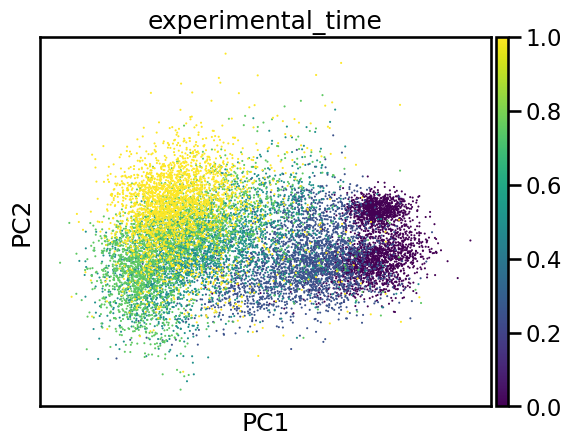

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


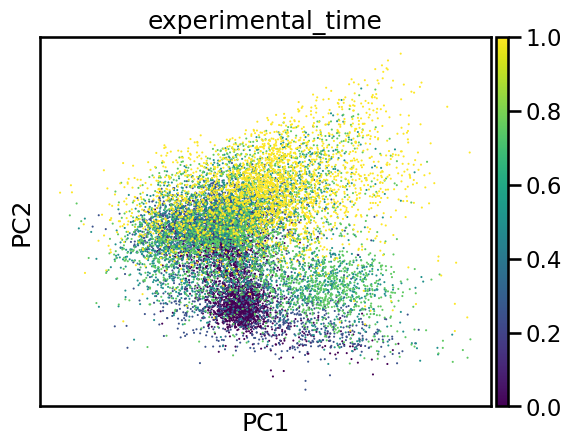

In [19]:
# Adata simulated non-flat
adata_simulated_vae = anndata.AnnData(X=traj_vae.detach().numpy(), 
                                     obs=times_vae)
sc.tl.pca(adata_simulated_vae)
sc.pl.pca(adata_simulated_vae, color="experimental_time")

# Adata simulated flat
adata_simulated_flat = anndata.AnnData(X=traj_flat.detach().numpy(),
                                      obs=times_flat)
sc.tl.pca(adata_simulated_flat)
sc.pl.pca(adata_simulated_flat, color="experimental_time")

In [20]:
# UMAP simulated non-flat
sc.pp.neighbors(adata_simulated_vae, 30)
sc.tl.umap(adata_simulated_vae)

# UMAP simulated flat
sc.pp.neighbors(adata_simulated_flat, 30)
sc.tl.umap(adata_simulated_flat)

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10

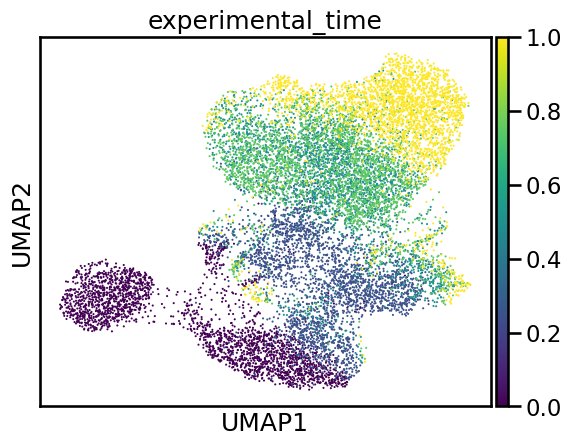

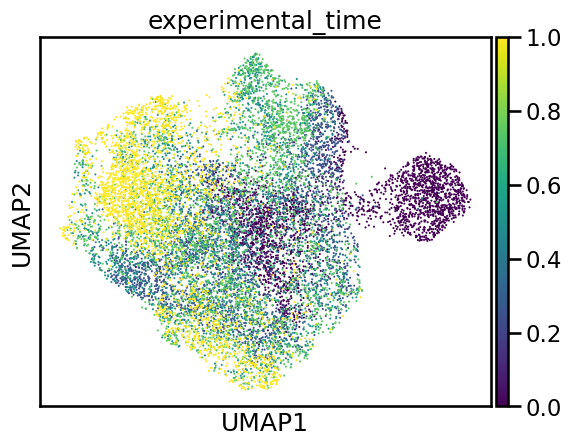

In [21]:
# Plot results
sc.pl.umap(adata_simulated_vae, color = "experimental_time")
sc.pl.umap(adata_simulated_flat, color = "experimental_time")

In [22]:
# Concatenate simulated and real distributions non-flat vae
concat_vae = anndata.concat([adata_simulated_vae, adata_latent_vae])
dataset_type = ["simulated" for i in range(len(adata_simulated_vae))] + ["real" for i in range(len(adata_latent_vae))]
concat_vae.obs["dataset_type"] = dataset_type

# Concatenate simulated and real distributions flat vae
concat_flat = anndata.concat([adata_simulated_flat, adata_latent_flat])
dataset_type = ["simulated" for i in range(len(adata_simulated_flat))] + ["real" for i in range(len(adata_latent_flat))]
concat_flat.obs["dataset_type"] = dataset_type

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


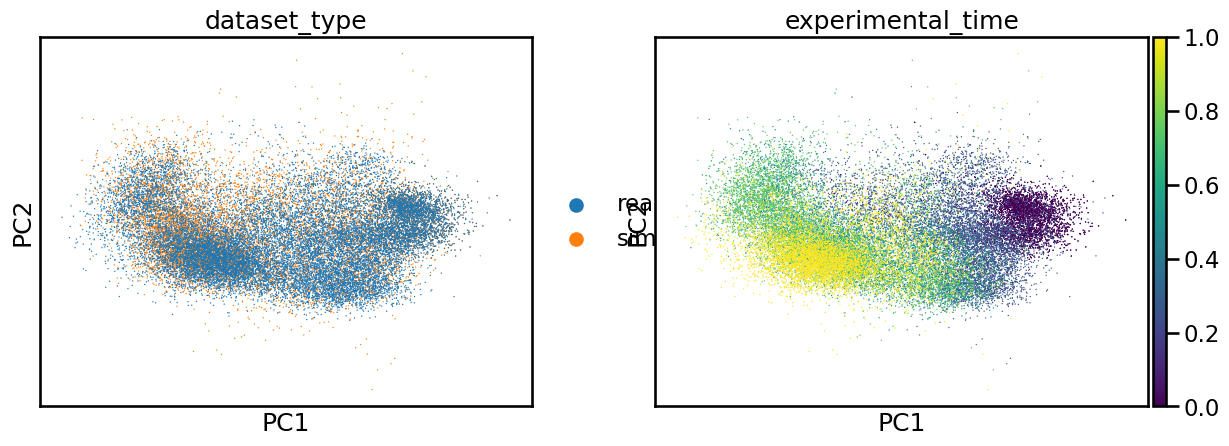

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


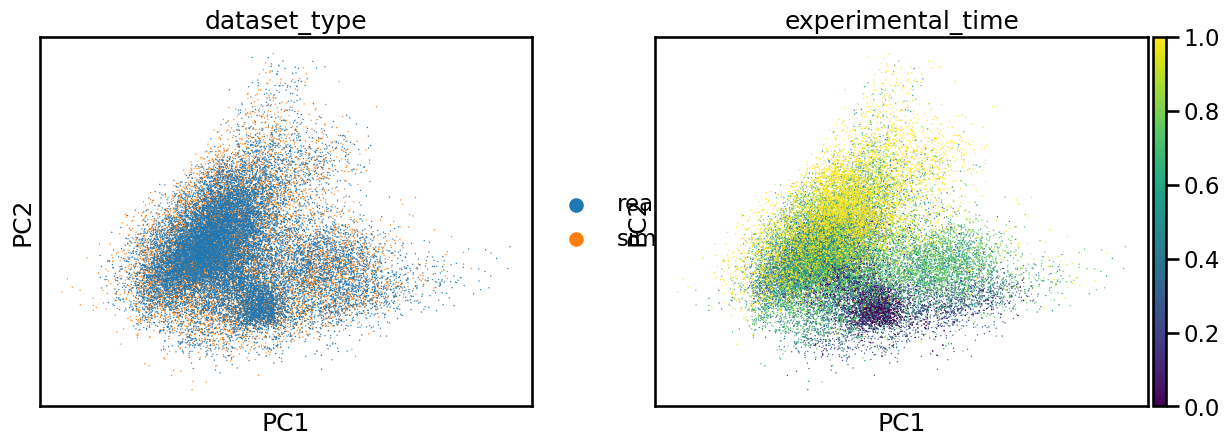

In [23]:
# PCA comparison simulated/real non-flat
sc.pp.pca(concat_vae)
sc.pl.pca(concat_vae, color=["dataset_type","experimental_time"])

# PCA comparison simulated/real flat
sc.pp.pca(concat_flat)
sc.pl.pca(concat_flat, color=["dataset_type","experimental_time"])

In [24]:
# UMAP comparison simulated/real non-flat
sc.pp.neighbors(concat_vae, 30)
sc.tl.umap(concat_vae)

# UMAP comparison simulated/real flat
sc.pp.neighbors(concat_flat, 30)
sc.tl.umap(concat_flat)

In [25]:
# concat_vae.uns["dataset_type_colors"] = ["firebrick", "dodgerblue"]
# concat_flat.uns["dataset_type_colors"] = ["firebrick", "dodgerblue"]

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


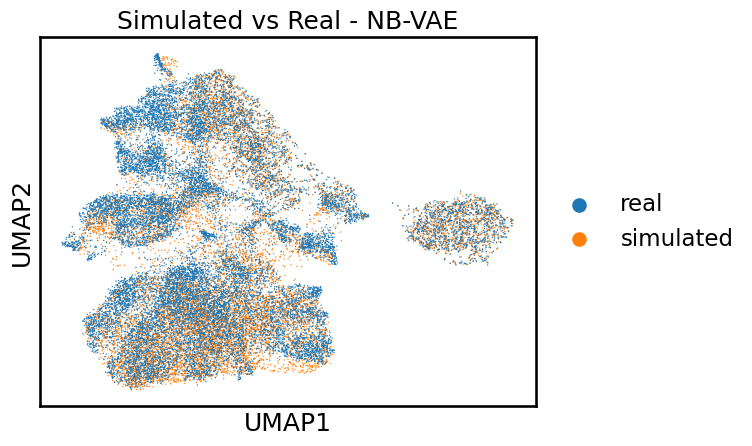

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


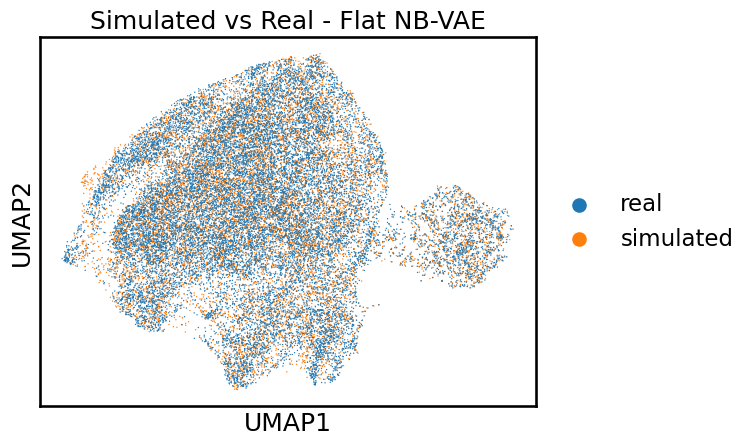

In [26]:
# Plot UMAP comparison simulated/real non-flat
sc.pl.umap(concat_vae, color = ["dataset_type"], title="Simulated vs Real - NB-VAE")

# Plot UMAP comparison simulated/real flat
sc.pl.umap(concat_flat, color = ["dataset_type"], title="Simulated vs Real - Flat NB-VAE")

**Decoded trajectories**

In [27]:
datamodule={'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate.h5ad', 
            'x_layer': 'X_norm', 
            'cond_keys': ['experimental_time', 'leiden'],
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [1], 
            'batch_size': 512, 
            'num_workers': 2}

# Initialize datamodule
datamodule = scDataModule(**datamodule)

Initialize variational autoencoders

In [28]:
model_vae={
       'in_dim': datamodule.in_dim,
       'n_epochs_anneal_kl': 1000, 
       'kl_weight': None, 
       'likelihood': 'nb', 
       'dropout': False, 
       'learning_rate': 0.001, 
       'dropout_p': False, 
       'model_library_size': True, 
       'batch_norm': True, 
       'kl_warmup_fraction': 0.1, 
       'hidden_dims': [256, 10]}
        
geometric={'compute_metrics_every': 1, 
           'use_c': True, 
           'l2': True, 
           'eta_interp': 0, 
           'interpolate_z': False, 
           'start_jac_after': 0, 
           'fl_weight': 0.1,
           'detach_theta': True}

In [29]:
# Initialize vae and geometric vae
vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).to(cfm_vae.device)
geometric_vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).to(cfm_vae.device)

In [30]:
# Load state dicts and put in eval mode 
vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_vae_lib.ckpt")["state_dict"])
geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_geometric_lib.ckpt")["state_dict"])

vae.eval()
geometric_vae.eval()

GeometricNBVAE(
  (encoder_layers): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1241, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
  )
  (decoder_layers): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=10, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
  )
  (library_size_decoder): Linear(in_features=10, out_features=1, bias=True)
  (decoder_mu_lib): Linear(in_features=256, out_features=1241, bias=True)
  (mu_logvar): Linear(in_features=256, out_features=20, bias=True)
)

Compute the trajectories 

In [31]:
# Collect data trajectories
mu_traj_vae, x_traj_vae, times_traj_vae = decode_trajectory(X_adata_t0_vae,
                                                            l_t0_vae,
                                                            cfm_vae,
                                                            vae,
                                                            idx2time, 
                                                            device, 
                                                            False)

mu_traj_flat, x_traj_flat, times_traj_flat = decode_trajectory(X_adata_t0_flat,
                                                               l_t0_flat,
                                                               cfm_flat,
                                                               geometric_vae,
                                                               idx2time, 
                                                               device, 
                                                               False)

Assemble the trajectories into anndata files

In [53]:
# Real time cells (for plotting)
times_traj_vae = pd.DataFrame(times_traj_vae)
times_traj_flat = pd.DataFrame(times_traj_flat)

times_traj_vae.columns = ["experimental_time"]
times_traj_flat.columns = ["experimental_time"]

# Create anndatas
adata_x_traj_vae = anndata.AnnData(X=mu_traj_vae.detach().numpy(), 
                                     obs=times_traj_vae)
adata_x_traj_flat = anndata.AnnData(X=mu_traj_flat.detach().numpy(),
                                      obs=times_traj_flat)

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


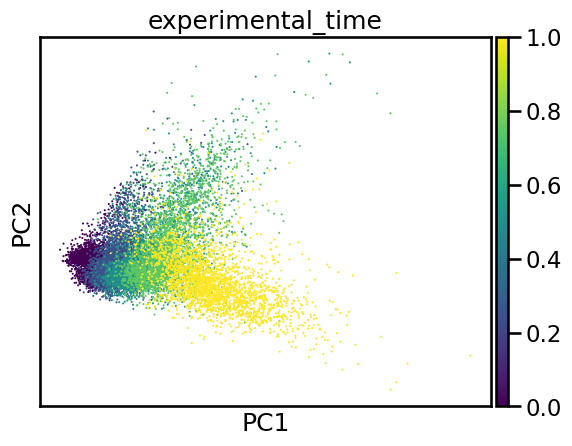

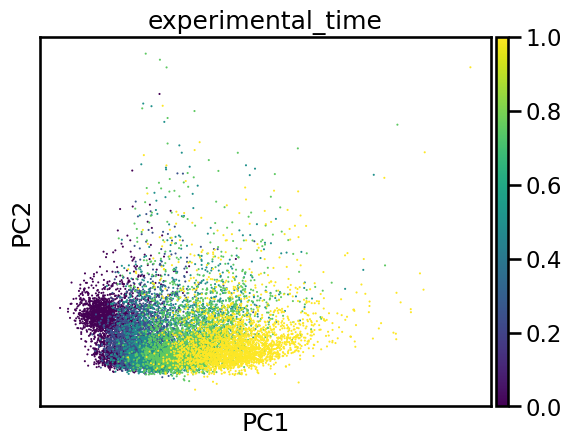

In [54]:
# PCA decoded trajectories VAE
sc.pp.pca(adata_x_traj_vae)
sc.pl.pca(adata_x_traj_vae, color=["experimental_time"])

# PCA decoded trajectories flat VAE
sc.pp.pca(adata_x_traj_flat)
sc.pl.pca(adata_x_traj_flat, color=["experimental_time"])

In [55]:
adata_x_traj_flat.X

array([[0.02794507, 0.02256162, 0.02410674, ..., 0.01772981, 0.12003617,
        0.01815747],
       [0.0245492 , 0.02284949, 0.02567652, ..., 0.01934249, 0.31621158,
        0.01668225],
       [0.02382262, 0.01999796, 0.0218289 , ..., 0.01626235, 0.49941492,
        0.01552203],
       ...,
       [0.02228058, 0.04906132, 0.0590204 , ..., 0.05920536, 0.8491956 ,
        0.01924171],
       [0.02864822, 0.05204179, 0.06552091, ..., 0.05792279, 2.028979  ,
        0.02341538],
       [0.03084212, 0.05404123, 0.06829341, ..., 0.06183999, 2.0763292 ,
        0.02484223]], dtype=float32)

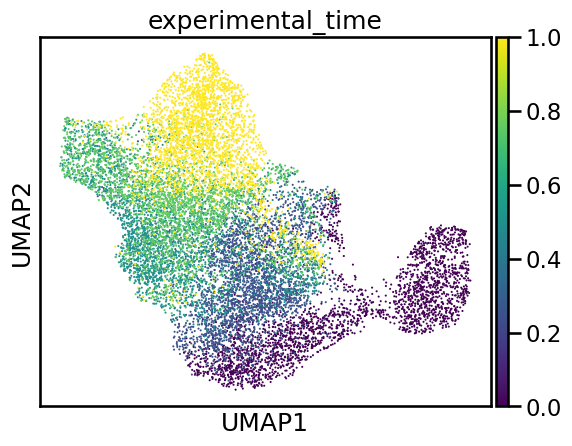

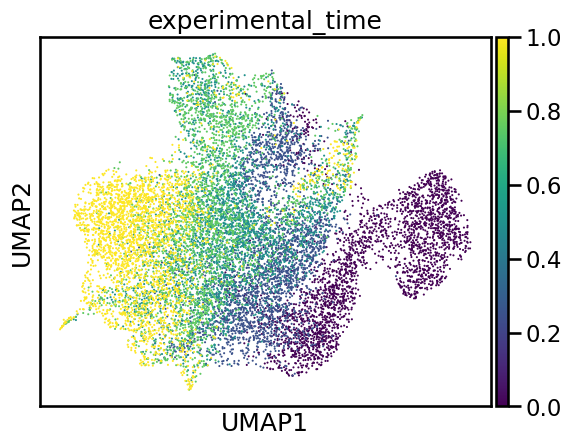

In [56]:
# UMAP decoded trajectories VAE
sc.pp.neighbors(adata_x_traj_vae, 30)
sc.tl.umap(adata_x_traj_vae)
sc.pl.umap(adata_x_traj_vae, color = ["experimental_time"])

# UMAP decoded trajectories flat VAE
sc.pp.log1p(adata_x_traj_flat)
sc.pp.neighbors(adata_x_traj_flat, 30)
sc.tl.umap(adata_x_traj_flat)
sc.pl.umap(adata_x_traj_flat, color = ["experimental_time"])

Read original data and collect the normalization layer

In [57]:
adata_eb_original = sc.read_h5ad('/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate.h5ad')
adata_eb_original.X = adata_eb_original.layers["X_norm"].copy()

Assemble anndata containing real data and generated data 

In [58]:
# Assign variable names to trajectory datasets
adata_x_traj_vae.var.index = adata_eb_original.var.index
adata_x_traj_flat.var.index = adata_eb_original.var.index

# Concatenate real anndata with simulated anndata vae
concat_vae_x = anndata.concat([adata_x_traj_vae, adata_eb_original])
dataset_type = ["simulated" for i in range(len(adata_x_traj_vae))] + ["real" for i in range(len(adata_eb_original))]
concat_vae_x.obs["dataset_type"] = dataset_type

# Concatenate real anndata with simulated anndata flat vae
concat_flat_x = anndata.concat([adata_x_traj_flat, adata_eb_original])
dataset_type = ["simulated" for i in range(len(adata_x_traj_flat))] + ["real" for i in range(len(adata_eb_original))]
concat_flat_x.obs["dataset_type"] = dataset_type

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


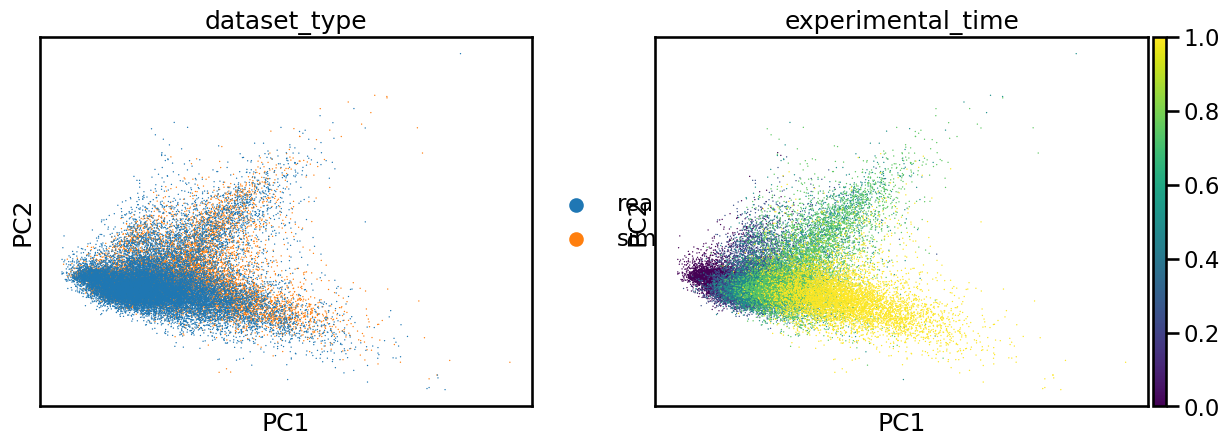

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


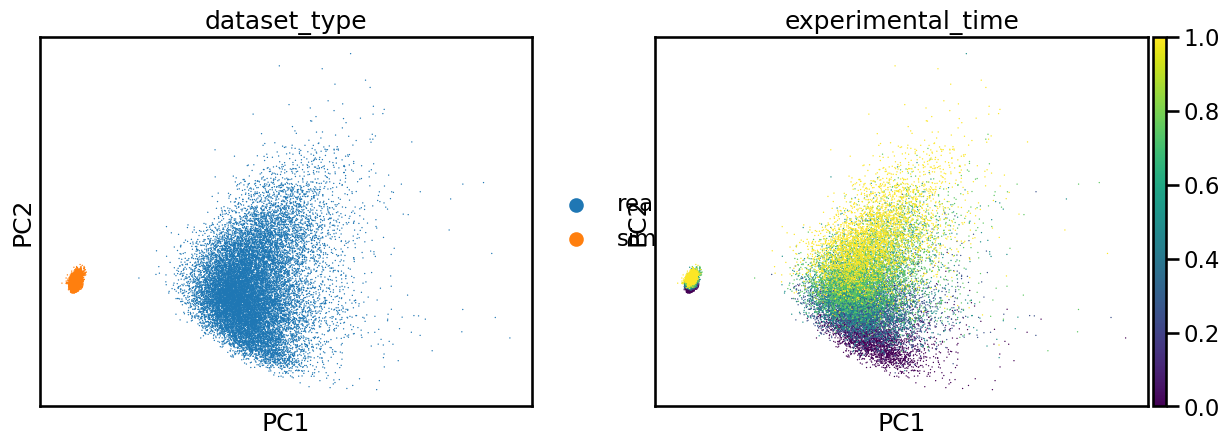

In [59]:
# PCA decoded trajectories real/simulated VAE
sc.pp.pca(concat_vae_x)
sc.pl.pca(concat_vae_x, color=["dataset_type","experimental_time"])

# PCA decoded trajectories real/simulated flat VAE
sc.pp.pca(concat_flat_x)
sc.pl.pca(concat_flat_x, color=["dataset_type","experimental_time"])

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


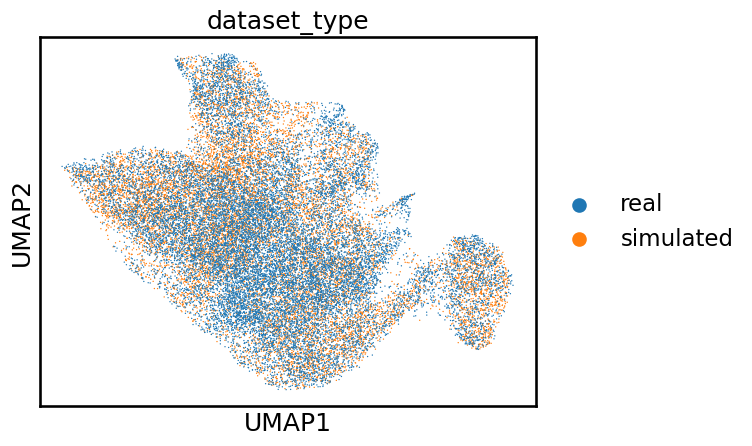

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


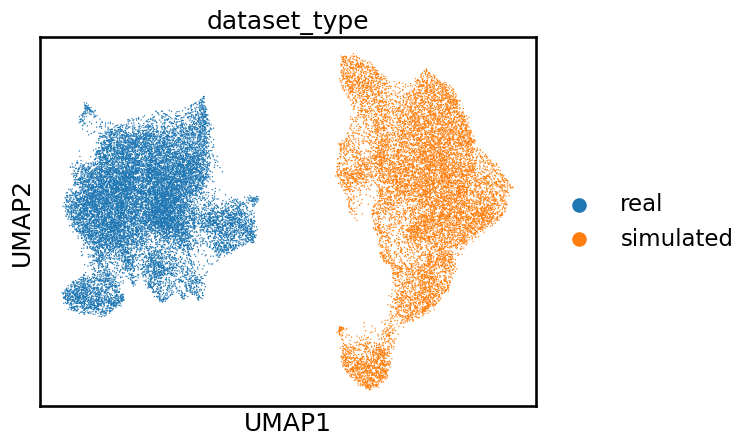

In [60]:
# UMAP decoded trajectories real/simulated VAE
sc.pp.neighbors(concat_vae_x, 30)
sc.tl.umap(concat_vae_x)
sc.pl.umap(concat_vae_x, color = ["dataset_type"])

# UMAP decoded trajectories real/simulated flat VAE
sc.pp.neighbors(concat_flat_x, 30)
sc.tl.umap(concat_flat_x)
sc.pl.umap(concat_flat_x, color = ["dataset_type"])

**Check scIB metrics latent space**

In [39]:
# concat_vae.obsm["X_latents"] = concat_vae.X.copy()
# concat_flat.obsm["X_latents"] = concat_flat.X.copy()

In [40]:
# bm_latent_vae = Benchmarker(
#     concat_vae[concat_vae.obs.experimental_time>0],
#     batch_key="dataset_type",
#     label_key="experimental_time",
#     embedding_obsm_keys=["X_latents", "X_umap"],
#     n_jobs=1,
# )
# bm_latent_vae.benchmark()
# bm_latent_vae.plot_results_table(min_max_scale=False)

In [41]:
# bm_latent_flat = Benchmarker(
#     concat_flat[concat_flat.obs.experimental_time>0],
#     batch_key="dataset_type",
#     label_key="experimental_time",
#     embedding_obsm_keys=["X_latents", "X_umap"],
#     n_jobs=2,
# )
# bm_latent_flat.benchmark()
# bm_latent_flat.plot_results_table(min_max_scale=False)

**Check scIB metrics data space**

In [42]:
# bm_vae = Benchmarker(
#     concat_vae_x,
#     batch_key="dataset_type",
#     label_key="experimental_time",
#     embedding_obsm_keys=["X_pca", "X_umap"],
#     n_jobs=1,
# )
# bm_vae.benchmark()
# bm_vae.plot_results_table(min_max_scale=False)

In [43]:
# bm_flat = Benchmarker(
#     concat_flat_x,
#     batch_key="dataset_type",
#     label_key="experimental_time",
#     embedding_obsm_keys=["X_pca", "X_umap"],
#     n_jobs=2,
# )
# bm_flat.benchmark()
# bm_flat.plot_results_table(min_max_scale=False)

**Check latent distribution reconstruction**

Standardize the two latent spaces of real and concatenated adata

In [44]:
standardize_adata(concat_vae, "X_std")
standardize_adata(concat_flat, "X_std")

Compute distribution distances 

In [45]:
# Compute latent distribution distances 
latent_distribution_distances_vae = {}
latent_distribution_distances_flat = {}

# Compute time-point specfic reconstruction
for i in range(1, len(idx2time)):
    # Non-flat VAE
    condition_vae = np.logical_and(concat_vae.obs.dataset_type=="simulated", 
                                   concat_vae.obs.experimental_time==idx2time[i])
    condition_real_vae = np.logical_and(concat_vae.obs.dataset_type=="real", 
                                   concat_vae.obs.experimental_time==idx2time[i])
    
    X_latents_vae = torch.from_numpy(concat_vae[condition_vae].layers["X_std"])
    X_latents_real_vae = torch.from_numpy(concat_vae[condition_real_vae].layers["X_std"])
    m_vae = compute_distribution_distances(X_latents_vae.unsqueeze(1), 
                                            X_latents_real_vae.unsqueeze(1))
    latent_distribution_distances_vae = add_keys_to_dict(latent_distribution_distances_vae, m_vae)
    
    # Non-flat VAE
    condition_flat = np.logical_and(concat_flat.obs.dataset_type=="simulated", 
                                   concat_flat.obs.experimental_time==idx2time[i])
    condition_real_flat = np.logical_and(concat_flat.obs.dataset_type=="real", 
                                   concat_flat.obs.experimental_time==idx2time[i])
    
    X_latents_flat = torch.from_numpy(concat_flat[condition_flat].layers["X_std"])
    X_latents_real_flat = torch.from_numpy(concat_flat[condition_real_flat].layers["X_std"])
    m_flat = compute_distribution_distances(X_latents_flat.unsqueeze(1), 
                                             X_latents_real_flat.unsqueeze(1))
    latent_distribution_distances_flat = add_keys_to_dict(latent_distribution_distances_flat, m_flat)

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(latent_distribution_distances_vae).mean(0)

In [ ]:
pd.DataFrame(latent_distribution_distances_flat).mean(0)

**Check data distribution reconstruction**

In [ ]:
adata_x_traj_vae.obsm["X_pca"] = (adata_x_traj_vae.obsm["X_pca"] - np.mean(adata_x_traj_vae.obsm["X_pca"], axis=0)) / np.std(adata_x_traj_vae.obsm["X_pca"], axis=0)
adata_x_traj_flat.obsm["X_pca"] = (adata_x_traj_flat.obsm["X_pca"] - np.mean(adata_x_traj_flat.obsm["X_pca"], axis=0)) / np.std(adata_x_traj_flat.obsm["X_pca"], axis=0)
adata_eb_original.obsm["X_pca"] = (adata_eb_original.obsm["X_pca"] - np.mean(adata_eb_original.obsm["X_pca"], axis=0)) / np.std(adata_eb_original.obsm["X_pca"], axis=0)

In [ ]:
# Compute PCA distribution distances 
data_distribution_distances_vae_x = {}
data_distribution_distances_flat_x = {}

# Compute time-point specfic reconstruction
for i in range(1, len(idx2time)):
    # Get pCA of data for right time point
    X_sim_vae = torch.from_numpy(adata_x_traj_vae[adata_x_traj_vae.obs["experimental_time"]==idx2time[i]].obsm["X_pca"])
    X_sim_flat = torch.from_numpy(adata_x_traj_flat[adata_x_traj_flat.obs["experimental_time"]==idx2time[i]].obsm["X_pca"])
    X_real_vae = torch.from_numpy(adata_eb_original[adata_eb_original.obs["experimental_time"]==idx2time[i]].obsm["X_pca"])
    
    # Compute for VAE
    m_data_vae = compute_distribution_distances(X_sim_vae.unsqueeze(1), 
                                                X_real_vae.unsqueeze(1))
    data_distribution_distances_vae_x = add_keys_to_dict(data_distribution_distances_vae_x, m_data_vae)
    
    # Compute for flat VAE    
    m_data_flat = compute_distribution_distances(X_sim_flat.unsqueeze(1), 
                                                 X_real_vae.unsqueeze(1))
    data_distribution_distances_flat_x = add_keys_to_dict(data_distribution_distances_flat_x, m_data_flat)

In [ ]:
pd.DataFrame(data_distribution_distances_vae_x).mean(0)

In [ ]:
pd.DataFrame(data_distribution_distances_flat_x).mean(0)